<h1 align="center">Regression</h1>

## Overview

This chapter covers

+ Ordinary Least Squares Linear Regression

+ Evaluation of regression results using coefficient of determination and $R^2$ score

+ Lasso, Ridge and ElasticNets Regression

In [14]:
%matplotlib inline

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.cross_validation import KFold
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb

<br/>
<br/>

## Problem
We have a dataset of house median prices in the Boston area, and a set of economic, environmental and building attributes for each house.

The problem is to accurately predict median price of unseen houses.

<br/>
<br/>
## Terminology

+ **Regressors** are the **explanatory variables** used for modelling the relationship. Other terms are **independent variables** and **predictor variables**.

<br/>

+ The **dependent variable** is also called **regressand** or **response variable**.

<br/>

+ Phrases like _"regression of W on Z"_ or _"we regress W on Z"_ means we predict W based on Z. W is the dependent, Z is the predictor variable.

<br/>

+ **Simple Regression** is when just one explanatory variable is used to predict a single scalar dependent variable.

<br/>

+ **Multiple / Multivariable Regression** is when more than one explanatory variables are used to predict a single scalar dependent variable.

<br/>

+ **Multivariate Regression** is when regression is used to predict multiple correlated dependent variables, ie, predicting a vector of dependent variables. Don't confuse multi _variate_ with multi _variable_.

<br/>
<br/>
## Understanding the concept of _Linear model_

The idea behind Linear Regression is that dependent variable can be modelled as a linear combination of the predictor variables.

$$ y = X\beta + \epsilon $$

where $\beta$ are called the **parameters** or **coefficients** of the model.

It's important to understand here that the linearity refers to the _parameters_, not to the _predictor variables_.

For example, if the distance travelled with respect to time ($s = ut + {1\over2}gt^2$) can be modelled as $y = \beta_1 t + \beta_2 t^2+ \epsilon $, its parameters can be calculated using linear regression. Even though the function is nonlinear with respect to time t, we can use regressors $(x_1, x_2) = (t, t^2)$ to make it linear with respect to parameters {$\beta_1, \beta_2$}.

<br/>
<br/>
## Exploring the dataset

Regression techniques are explored and evaluated using the _Boston House Prices_ dataset.

In [15]:
boston = load_boston()
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [16]:
bdata = boston.data
bdata.shape

(506, 13)

In [17]:
bdata[:3]

array([[  6.32000000e-03,   1.80000000e+01,   2.31000000e+00,
          0.00000000e+00,   5.38000000e-01,   6.57500000e+00,
          6.52000000e+01,   4.09000000e+00,   1.00000000e+00,
          2.96000000e+02,   1.53000000e+01,   3.96900000e+02,
          4.98000000e+00],
       [  2.73100000e-02,   0.00000000e+00,   7.07000000e+00,
          0.00000000e+00,   4.69000000e-01,   6.42100000e+00,
          7.89000000e+01,   4.96710000e+00,   2.00000000e+00,
          2.42000000e+02,   1.78000000e+01,   3.96900000e+02,
          9.14000000e+00],
       [  2.72900000e-02,   0.00000000e+00,   7.07000000e+00,
          0.00000000e+00,   4.69000000e-01,   7.18500000e+00,
          6.11000000e+01,   4.96710000e+00,   2.00000000e+00,
          2.42000000e+02,   1.78000000e+01,   3.92830000e+02,
          4.03000000e+00]])

In [18]:
prices = boston.target
prices[:5]

array([ 24. ,  21.6,  34.7,  33.4,  36.2])

In [33]:
# We also calculate the Bk value (proportion of blacks) from B. 
# I think the idea behind B column is like this: the maximum proportion of blacks in survey is 0.63
# If the proportion is close to this maximum, B value is relatively high
# If the proportion is very low and very far from this maximum, B value is low.
bk = np.sqrt(bdata[:,11] / 1000)

boston_df = pd.DataFrame(data = np.c_[bdata,bk,prices],
                         columns = list(boston['feature_names']) + ['BK', 'price'])

In [34]:
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,BK,price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,0.630000,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,0.630000,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,0.626762,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,0.628196,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,0.630000,36.2


In [35]:
boston_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,BK,price
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,0.586303,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,0.113792,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,0.017889,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,0.612681,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,0.625652,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,0.629464,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,0.630000,50.000000


<br/>
<br/>
### Correlation Matrix

We draw a correlation matrix to find out which explanatory variables correlate highly with each other, as well which ones explain the output price best.

In [36]:
corr = boston_df.corr()
corr

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,BK,price
CRIM,1.000000,-0.199458,0.404471,-0.055295,0.417521,-0.219940,0.350784,-0.377904,0.622029,0.579564,0.288250,-0.377365,0.452220,-0.378114,-0.385832
ZN,-0.199458,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.161902,0.360445
INDUS,0.404471,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.329525,-0.483725
CHAS,-0.055295,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.052462,0.175260
NOX,0.417521,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.348658,-0.427321
RM,-0.219940,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.108286,0.695360
AGE,0.350784,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.250592,-0.376955
DIS,-0.377904,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.270628,0.249929
RAD,0.622029,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.435129,-0.381626
TAX,0.579564,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.425038,-0.468536


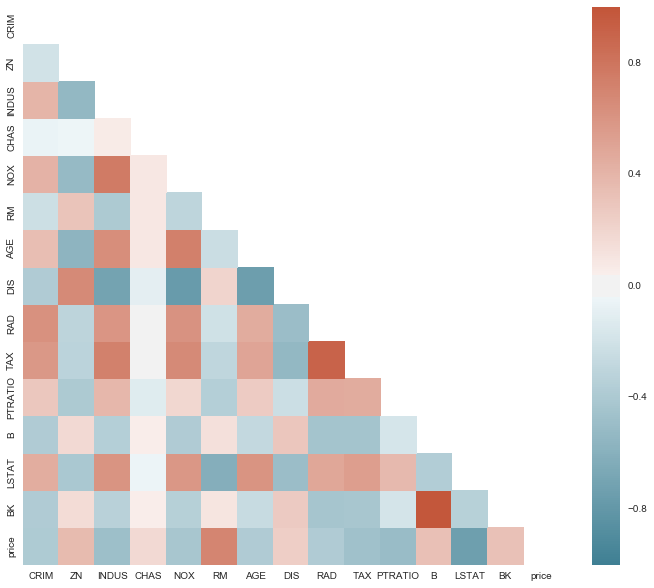

In [37]:
# Correlation plot based on https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html

plt.figure(figsize=(12, 10))
sb.set(style="white")

# Create a mask to display just the lower triangle.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sb.heatmap(corr, 
           cmap = sb.diverging_palette(220, 20, as_cmap=True),
           mask = mask)
plt.show()

sb.set(style="darkgrid")

There are some interesting observations in that correlation plot:

+ _price_ is highly positively correlated to _number of rooms_ (RM).

+ _price_ is highly _negatively_ correlated to _percentage of lower status of population_ (LSTAT).

+ There are also many interesting correlations between the explanatory variables themselves, suggesting that some pairs are not independent.

<br/>
<br/>
## Univariate or Simple Regression model - Regression with just a single variable

First, we perform regression with just a single variable - RM, the average number of rooms per house.

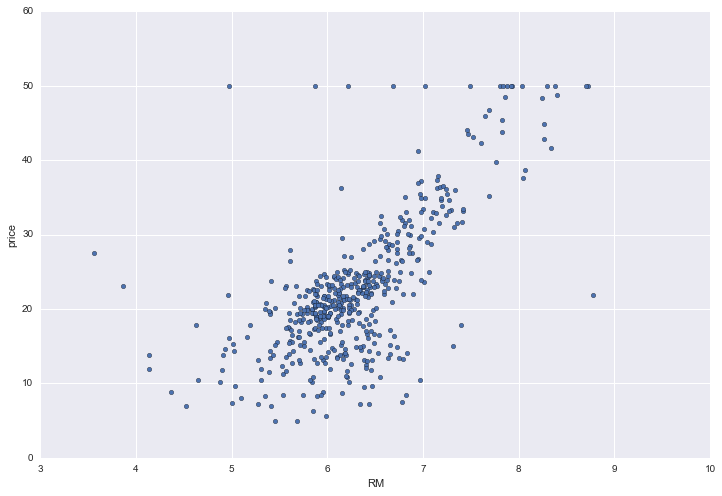

In [38]:
boston_df.plot('RM', 'price', kind='scatter', figsize=(12,8))
plt.show()

In [39]:
lr = LinearRegression()
X = boston_df.RM
# LR does not accept 1D array. It should be reshaped to 2D array
X = X.reshape(-1, 1)
y_actual = boston_df.price
lr.fit(X, y_actual)
y_pred = lr.predict(X)

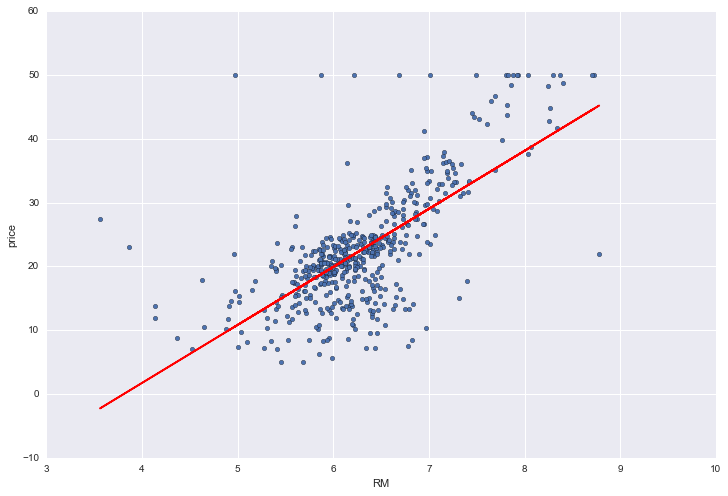

In [40]:
boston_df.plot('RM', 'price', kind='scatter', figsize=(12,8))
plt.plot(X, y_pred, color='red')
plt.show()

### Evaluation of model fit

The goodness of fit of a linear regression model is calculated using a metric known as the **Coefficient of Determination**, denoted by $R^2$ (pronounced "R-squared").

R-squared is the "percent of variance explained" by the model.  That is, R-squared is the fraction by which the variance of prediction errors is less than the variance of the dependent variable.

If we didn't know anything about the input data other than the prices, then our best prediction would simply be the mean of the output variable, $\bar y$. The sum of squared errors would then be $\sum (y_i - \bar y)^2$, which is nothing but the _variance_ of the variable.

$R^2$ is defined as the ratio of the sum of squared errors of predicted model to this intrinsic variance. 

$$ R^2 = 1 - {\sum (y_i - \hat y)^2 \over \sum (y_i - \bar y)^2 } $$



A perfect model would predict $\hat y = y_i$, and result in an $R^2$ value of 1.

A mean model would predict $\hat y = \bar y$, and result in an $R^2$ value of 0.

<br/>
<br/>
Scikit-learn provides two ways to calculate the $R^2$ value:

+ `sklearn.metrics.r2_score(y_true, y_pred)`

or

+ `score(X, y)` method of `sklearn.linear_model.LinearRegression` class

In [41]:
lr.score(X, y_actual)

0.48352545599133429

In [42]:
r2_score(y_actual, y_pred)

0.48352545599133423

So our univariate model has a $R^2$ score of around 0.48.

<br/>
<br/>
<br/>

## Multple Regression model - Regression using all explanatory variables

In [43]:
lr_mult = LinearRegression()

X_mult = boston_df.ix[:, 0:-1]

lr_mult.fit(X_mult, y_actual)
y_pred_mult = lr_mult.predict(X_mult)

r2 = r2_score(y_actual, y_pred_mult)

rmse = np.sqrt(mean_squared_error(y_actual, y_pred_mult))

print('R2 score=', r2)
print('RMSE=', rmse)
print('Coefficients=', lr_mult.coef_)


R2 score= 0.742133242421
RMSE= 4.66572579801
Coefficients= [ -1.02528514e-01   4.62836725e-02   1.68126222e-02   2.68647827e+00
  -1.82981497e+01   3.84475819e+00   4.56980898e-04  -1.48278912e+00
   3.09445611e-01  -1.25286634e-02  -9.35769934e-01  -1.61653305e-02
  -5.27672262e-01   2.06133020e+01]


By using all the explanatory variables in the model, the $R^2$ score has been improved from 0.48 to 0.74

<br/>
<br/>
Does normalization of predictor variables change the output values?

In [44]:
lr_mult_with_norm = LinearRegression(normalize=True)

lr_mult_with_norm.fit(X_mult, y_actual)
y_pred_mult_norm = lr_mult_with_norm.predict(X_mult)

r2 = r2_score(y_actual, y_pred_mult_norm)

rmse = np.sqrt(mean_squared_error(y_actual, y_pred_mult_norm))

print('R2 score=', r2)
print('RMSE=', rmse)
print('Coefficients=', lr_mult_with_norm.coef_)


R2 score= 0.742133242421
RMSE= 4.66572579801
Coefficients= [ -1.02528514e-01   4.62836725e-02   1.68126222e-02   2.68647827e+00
  -1.82981497e+01   3.84475819e+00   4.56980898e-04  -1.48278912e+00
   3.09445611e-01  -1.25286634e-02  -9.35769934e-01  -1.61653305e-02
  -5.27672262e-01   2.06133020e+01]


We can see that normalization does not seem to have any effect at all on R-squared or RMSE.

<br/>
<br/>

## Cross validation for regression

So far, the only error that has been evaluated is the _training error_. Even though OLS linear regression, being a very simple model, is unlikely to suffer from overfitting, it is till good ML practice to evaluate every model for its generalizability by calculating its test error. 

For using CV for regression, we take the following approach:

+ Split the data into k pairs of {training, test} subsets.

+ For each training/test pair:

    - Train a linear regression model on current training subset
    
    - Calculate output variable on test subset
    
    - Store calculated outputs in a common array. Since cross validation ensures that all observations are covered by exactly one of the test subsets, we will have calculated outputs for all observations when cross validation ends.
    
First, we test that our assumption about coverage of every observation in just one of the test subsets is correct:

In [45]:
print('Without shuffling')
tmp = np.zeros((12,3))
tf = KFold(len(tmp), n_folds = 4)
for tr,ts in tf:
    print(ts)
    
print('With shuffling')
tf = KFold(len(tmp), n_folds = 4, shuffle=True)
for tr,ts in tf:
    print(ts)

Without shuffling
[0 1 2]
[3 4 5]
[6 7 8]
[ 9 10 11]
With shuffling
[1 3 5]
[ 4  8 10]
[ 2  9 11]
[0 6 7]


We can see that in regular KFold without shuffling, every fold gets to be the test set in sequence. 

But with shuffling, every test set is a random subset, with sklearn ensuring that no observation is duplicated in different test subsets. This shows that KFold with shuffling is the better option for evaluating generalizability.

<br/>

Cross validation without shuffling:

In [46]:
y_pred_cv = np.zeros_like(y_actual)

folds = KFold(len(X_mult), n_folds=5, shuffle =  False)
for train, test in folds:
    lr_mult_cv = LinearRegression()
    lr_mult_cv.fit(X_mult.ix[train], y_actual.ix[train])
    y_pred_cv[test] = lr_mult_cv.predict(X_mult.ix[test])
    
r2_cv = r2_score(y_actual, y_pred_cv)

rmse_cv = np.sqrt(mean_squared_error(y_actual, y_pred_cv))

print('CV R2 score=', r2_cv)
print('CV RMSE=', rmse_cv)

CV R2 score= 0.531816454815
CV RMSE= 6.28679943088


<br/>
Cross validation with shuffling:

In [47]:
y_pred_cv = np.zeros_like(y_actual)

folds = KFold(len(X_mult), n_folds=5, shuffle=True)
for train, test in folds:
    lr_mult_cv = LinearRegression()
    lr_mult_cv.fit(X_mult.ix[train], y_actual.ix[train])
    y_pred_cv[test] = lr_mult_cv.predict(X_mult.ix[test])
    
r2_cv = r2_score(y_actual, y_pred_cv)

rmse_cv = np.sqrt(mean_squared_error(y_actual, y_pred_cv))

print('CV R2 score=', r2_cv)
print('CV RMSE=', rmse_cv)

CV R2 score= 0.70376365761
CV RMSE= 5.00081398793


We see that cross validation with shuffling results in better $R^2$ score and lower RMSE than without shuffling.

<br/>
<br/>

## Regularized or Penalized Regression

OLS may result in a low bias but high variance model. The low bias is due to overfitting on training data, but at the cost of high variance when predicting unseen observations.

One way to reduce this variance is to use a subset of the most useful predictors. These methods are called _Subset selection methods_.

Another somewhat equivalent way is by shrinking or zeroing the parameters / weights of some of the predictors. This results in increasing the bias - and the training error - but is likely to generalize better. There are called _Shrinkage Methods_.

The idea here is that the model include the values of the parameters directly in the cost function so that higher weights increase the error. The optimization then naturally tries to reduce the values of these parameters. There are three types of penalties based on how we include these parameters:

+ **L1-penalties**

   The model penalizes the <span style="color:red">_absolute values_</span> of the weights.
   
<br/>

+ **L2-penalties**

   The model penalizes the <span style="color:red">_squared values_</span> of the weights.

<br/>

+ **Combination of L1 and L2 penalties**

   The model penalizes both absolute and squared values of the weights.

<br/>

Accordingly, we have 3 shrinkage methods:

**1. Lasso Regression**

Includes the L1-penalty in cost function.
   
If $\beta$ are the parameters, then the objective is to minimize the following cost function with absolute parameters:

$$ \sum_{i=1}^{n} (y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij})^2 + \color{red} {\alpha \sum_{j=1}^{p} \ \bigl| \ \beta_j \ \bigr|} $$

<br/>

**2. Ridge Regression**

Includes the L2-penalty in cost function.
   
If $\beta$ are the parameters, then the objective is to minimize the following cost function with squared parameters:

$$ \sum_{i=1}^{n} (y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij})^2 + \color{red} {\alpha \sum_{j=1}^{p} \beta_j ^ 2} $$

<br/>

**3. ElasticNet**

Includes both L1- and L2-penalty in cost function.

$$ \sum_{i=1}^{n} (y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij})^2 + \color{red} {\alpha_1 \sum_{j=1}^{p} \beta_j ^ 2 + \alpha_2 \sum_{j=1}^{p} \ \bigl| \ \beta_j \ \bigr| } $$

<br/>
<br/>

## Lasso Regression

Lasso Regresion is a shrinkage method that imposes a cost on the absolute values of parameters to drive them towards zero.

$$ \sum_{i=1}^{n} (y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij})^2 + \color{red} {\alpha \sum_{j=1}^{p} \ \bigl| \ \beta_j \ \bigr|} $$

Because Lasso can set some parameters exactly to zero when $\alpha$ is sufficiently large, it's also effectively doing **feature selection** in the same step, by discarding some features. As a result, Lasso models often result in **sparse** models.


In the following experiment, we check Lasso models with various values for $\alpha$ and check the training R-squared and RMSE values.

Notice that as $\alpha$ becomes large, more and more features get dropped.

With $\alpha >= 0.6$, Lasso consistently drops these 4 features:

+ INDUS    proportion of non-retail business acres per town
+ CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
+ NOX      nitric oxides concentration (parts per 10 million)
+ BK       The proportion of blacks (which makes sense because it's highly correlated with B)

<br/>

**Range of $\alpha$:**

$\alpha$ can take any value in $[0, \infty]$. It's not necessary that it's in $[0,1]$.
But because it adds to cost, it makes sense that it's usually a small number in $[0,1]$.

In [49]:
alphas = np.linspace(0.1,1.0,10)
for alpha in alphas:
    print('\nLasso with alpha=', alpha)
    
    las = Lasso(alpha = alpha)
    las.fit(X_mult, y_actual)
    y_pred_las = las.predict(X_mult)
    r2 = r2_score(y_actual, y_pred_las)

    rmse = np.sqrt(mean_squared_error(y_actual, y_pred_las))

    print('\tR2 score=', r2)
    print('\tRMSE=', rmse)
    print('\tCoefficients=', las.coef_)


Lasso with alpha= 0.1
	R2 score= 0.726914693175
	RMSE= 4.80143107781
	Coefficients= [-0.09678792  0.04917922 -0.03642541  0.95709698 -0.          3.69894259
 -0.01000634 -1.16012114  0.27411189 -0.01456675 -0.77100252  0.01032665
 -0.56950927  0.        ]

Lasso with alpha= 0.2
	R2 score= 0.722766975464
	RMSE= 4.8377565961
	Coefficients= [-0.0946275   0.04955324 -0.02321077  0.         -0.          3.40184619
 -0.00503097 -1.10295306  0.28122213 -0.01516912 -0.77929963  0.01022905
 -0.59511384  0.        ]

Lasso with alpha= 0.3
	R2 score= 0.720562468174
	RMSE= 4.85695299649
	Coefficients= [ -9.05881706e-02   4.97201161e-02  -1.76515804e-02   0.00000000e+00
  -0.00000000e+00   3.09182210e+00  -9.33420115e-04  -1.04019584e+00
   2.80048399e-01  -1.52748917e-02  -7.72353814e-01   9.98417006e-03
  -6.17479065e-01   0.00000000e+00]

Lasso with alpha= 0.4
	R2 score= 0.717759384586
	RMSE= 4.88125265506
	Coefficients= [ -8.66700722e-02   4.94664523e-02  -1.09537236e-02   0.00000000e+00
  -0.

<br/>

## Selecting Lasso parameter using Cross Validation

We know that when using k-fold cross validation, we predict values fold by fold, by training a model on all the other folds.

But during each training, we also want to find out which is the best value of the Lasso parameter $\alpha$. 

So a _second_ level of k-fold cross validation - for finding best $\alpha$ - is done on each of the training sets of the first level of k-folds.

This 2-level cross validation can be easily implemented using the `LassoCV` class. It performs the inner cross validation loop to find best $\alpha$ ,  given a list of $\alpha$s to evaluate, or alternatively a step size for $\alpha$. The application just has to perform the outer cross validation as with any other model.

In [92]:
# Use Lasso with 5-fold inner cross validation.
alphas = np.linspace(0.05,0.99,20)
las_cv = LassoCV(alphas=alphas, cv=5)

las_cv_outputs = np.zeros_like(y_actual)

kf = KFold(len(X_mult), n_folds=5, shuffle=True)

for train, test in kf:
    las_cv.fit(X_mult.ix[train], y_actual.ix[train])
    las_cv_outputs[test] = las_cv.predict(X_mult.ix[test])

r2_las_cv = r2_score(y_actual, las_cv_outputs)

rmse_las_cv = np.sqrt(mean_squared_error(y_actual, las_cv_outputs))

print('Lasso CV R2 score=', r2_las_cv)
print('Lasso CV RMSE=', rmse_las_cv)
print('Lasso CV Optimum alpha=', las_cv.alpha_)

Lasso CV R2 score= 0.695168478988
Lasso CV RMSE= 5.07284355231
Lasso CV Optimum alpha= 0.445789473684


Note that the optimum value changes quite wildly with each run.

<br/>
<br/>
## Ridge Regresion

Ridge Regresion is another shrinkage method that imposes a cost on the squared values of parameters to drive them towards zero.

$$ \sum_{i=1}^{n} (y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij})^2 + \color{red} {\alpha \sum_{j=1}^{p} \beta_j^2} $$

In [95]:
alphas = np.linspace(0.1,1.0,10)
for alpha in alphas:
    print('\nRidge with alpha=', alpha)
    
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_mult, y_actual)
    y_pred_ridge = ridge.predict(X_mult)
    r2 = r2_score(y_actual, y_pred_ridge)

    rmse = np.sqrt(mean_squared_error(y_actual, y_pred_ridge))

    print('\tR2 score=', r2)
    print('\tRMSE=', rmse)
    print('\tCoefficients=', ridge.coef_)


Ridge with alpha= 0.1
	R2 score= 0.74184181992
	RMSE= 4.66836148776
	Coefficients= [ -1.03829832e-01   4.64816099e-02   1.37982202e-02   2.67047259e+00
  -1.69935166e+01   3.83723886e+00  -4.04441787e-04  -1.46370312e+00
   3.05324406e-01  -1.25358561e-02  -9.30677286e-01  -5.81440674e-03
  -5.28013062e-01   1.23110885e+01]

Ridge with alpha= 0.2
	R2 score= 0.741470844274
	RMSE= 4.67171452251
	Coefficients= [ -1.04142219e-01   4.66366818e-02   1.04373700e-02   2.65512027e+00
  -1.59403442e+01   3.83746327e+00  -1.20809462e-03  -1.44824117e+00
   3.02407809e-01  -1.25785535e-02  -9.23079700e-01  -1.31485413e-03
  -5.28732923e-01   8.72242308e+00]

Ridge with alpha= 0.3
	R2 score= 0.741130991456
	RMSE= 4.67478414517
	Coefficients= [ -1.04153436e-01   4.67694219e-02   7.22175827e-03   2.64051441e+00
  -1.50340023e+01   3.83966206e+00  -1.93556816e-03  -1.43491719e+00
   3.00051196e-01  -1.26286750e-02  -9.15334560e-01   1.20502351e-03
  -5.29524292e-01   6.72585290e+00]

Ridge with alpha

<br/>

## Selecting Ridge parameter using Cross Validation

We know that when using k-fold cross validation, we predict values fold by fold, by training a model on all the other folds.

But during each training, we also want to find out which is the best value of the Lasso parameter $\alpha$. 

So a _second_ level of k-fold cross validation - for finding best $\alpha$ - is done on each of the training sets of the first level of k-folds.

This 2-level cross validation can be easily implemented using the `RidgeCV` class. It performs the inner cross validation loop to find best $\alpha$ ,  given a list of $\alpha$s to evaluate, or alternatively a step size for $\alpha$. The application just has to perform the outer cross validation as with any other model.

In [98]:
# Use Ridge with 5-fold inner cross validation.
alphas = np.linspace(0.05,0.99,20)
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv_outputs = np.zeros_like(y_actual)

kf = KFold(len(X_mult), n_folds=5, shuffle=True)

for train, test in kf:
    ridge_cv.fit(X_mult.ix[train], y_actual.ix[train])
    ridge_cv_outputs[test] = ridge_cv.predict(X_mult.ix[test])

r2_ridge_cv = r2_score(y_actual, ridge_cv_outputs)

rmse_ridge_cv = np.sqrt(mean_squared_error(y_actual, ridge_cv_outputs))

print('Ridge CV R2 score=', r2_ridge_cv)
print('Ridge CV RMSE=', rmse_ridge_cv)
print('Ridge CV Optimum alpha=', ridge_cv.alpha_)

Ridge CV R2 score= 0.721299172802
Ridge CV RMSE= 4.85054637463
Ridge CV Optimum alpha= 0.99


<br/>
<br/>
## ElasticNet

ElasticNet Regresion is another shrinkage method that imposes a cost on both the absolute values and squared values of parameters to drive them towards zero.

$$ \sum_{i=1}^{n} (y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij})^2 + \color{red} {\alpha_1 \sum_{j=1}^{p} \ \bigl| \ \beta_j \ \bigr| + \alpha_2 \sum_{j=1}^{p} \beta_j ^ 2} $$

$\alpha_1$ and $\alpha_2$ are themselves related through 2 other parameters $\rho$, the $l_1$-ratio and $\alpha$ as follows:
$$ \alpha_1 = \rho \alpha $$

$$ \alpha_2 = (1 - \rho) \alpha $$

$\rho$ is a parameter to scale L1 vs L2 penalty:
+ If $\rho$ is 0, it's the same as Ridge regression.

+ If $\rho$ is 1, it's the same as Lasso regression

+ If $\rho$ is between 0 and 1, both penalties are included.

In [99]:
alphas = np.linspace(0.1,1.0,10)
for alpha in alphas:
    print('\nElasticNet with alpha=', alpha)
    
    en = ElasticNet(alpha=0.5, l1_ratio=0.1)
    en.fit(X_mult, y_actual)
    y_pred_en = en.predict(X_mult)
    r2 = r2_score(y_actual, y_pred_en)

    rmse = np.sqrt(mean_squared_error(y_actual, y_pred_en))

    print('\tR2 score=', r2)
    print('\tRMSE=', rmse)
    print('\tCoefficients=', en.coef_)


ElasticNet with alpha= 0.1
	R2 score= 0.70347039007
	RMSE= 5.00328872417
	Coefficients= [-0.09797628  0.05538955 -0.04710799  0.24585173 -0.          1.4971837
  0.01175821 -1.00471604  0.32658443 -0.01654738 -0.8183485   0.0089031
 -0.71927909  0.        ]

ElasticNet with alpha= 0.2
	R2 score= 0.70347039007
	RMSE= 5.00328872417
	Coefficients= [-0.09797628  0.05538955 -0.04710799  0.24585173 -0.          1.4971837
  0.01175821 -1.00471604  0.32658443 -0.01654738 -0.8183485   0.0089031
 -0.71927909  0.        ]

ElasticNet with alpha= 0.3
	R2 score= 0.70347039007
	RMSE= 5.00328872417
	Coefficients= [-0.09797628  0.05538955 -0.04710799  0.24585173 -0.          1.4971837
  0.01175821 -1.00471604  0.32658443 -0.01654738 -0.8183485   0.0089031
 -0.71927909  0.        ]

ElasticNet with alpha= 0.4
	R2 score= 0.70347039007
	RMSE= 5.00328872417
	Coefficients= [-0.09797628  0.05538955 -0.04710799  0.24585173 -0.          1.4971837
  0.01175821 -1.00471604  0.32658443 -0.01654738 -0.8183485   

<br/>

## Selecting ElasticNet parameters using Cross Validation

We know that when using k-fold cross validation, we predict values fold by fold, by training a model on all the other folds.

But during each training, we also want to find out which is the best values for the ElasticNet parameters $\rho$ and $\alpha$. 

So a _second_ level of k-fold cross validation - for finding best $\rho$ and $\alpha$ - is done on each of the training sets of the first level of k-folds.

This 2-level cross validation can be easily implemented using the `ElasticNetCV` class. It performs the inner cross validation loop to find best $\alpha$ ,  given a list of $\alpha$s to evaluate, or alternatively a step size for $\alpha$. The application just has to perform the outer cross validation as with any other model.

In [108]:
# Use ElasticNet with 5-fold inner cross validation.
alphas = np.linspace(0.05,0.99,20)

# Sklearn docs recommend that the L1-ratio search space be denser towards Lasso than towards Ridge
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99]
en_cv = ElasticNetCV(l1_ratio = l1_ratios, alphas = alphas)

en_cv_outputs = np.zeros_like(y_actual)

kf = KFold(len(X_mult), n_folds=5, shuffle=True)

for train, test in kf:
    en_cv.fit(X_mult.ix[train], y_actual.ix[train])
    en_cv_outputs[test] = en_cv.predict(X_mult.ix[test])

r2_en_cv = r2_score(y_actual, en_cv_outputs)

rmse_en_cv = np.sqrt(mean_squared_error(y_actual, en_cv_outputs))

print('ElasticNet CV R2 score=', r2_en_cv)
print('ElasticNet CV RMSE=', rmse_en_cv)
print('ElasticNet CV Optimum alpha=', en_cv.alpha_)
print('ElasticNet CV Optimum l1-ratio rho=', en_cv.l1_ratio_)

ElasticNet CV R2 score= 0.688291818942
ElasticNet CV RMSE= 5.1297432972
ElasticNet CV Optimum alpha= 0.594210526316
ElasticNet CV Optimum l1-ratio rho= 0.3


**Plot of ElasticNet predictions vs actual prices:**

The diagonal line represents perfect fit line.

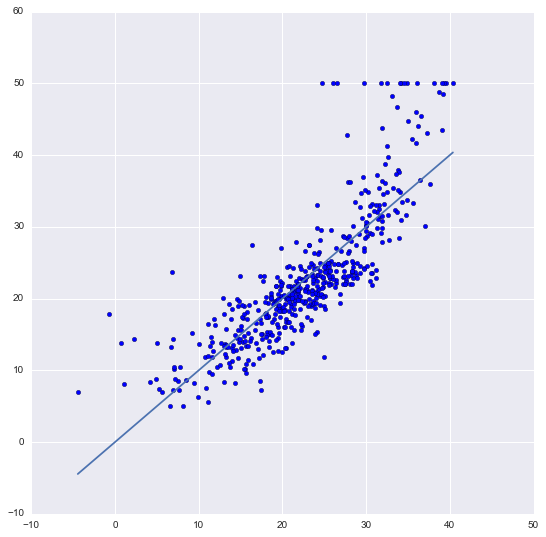

In [109]:
plt.figure(figsize=(9,9))
plt.scatter(en_cv_outputs, y_actual)
plt.plot([en_cv_outputs.min(), en_cv_outputs.max()], [en_cv_outputs.min(), en_cv_outputs.max()])
plt.show()

<br/>
<br/>

## Using Grid Search for hyperparameter tuning

TODO how to use grid search for tuning of Lasso, Ridge and ElasticNets


<br/>
<br/>

## Conclusions

ElasticNet with hyperparameter optimization should probably be the default regression model for any problem.

But check Lasso too, because it does feature selection and gives a sparse model. This information too may be useful in itself.

<br/>
<br/>
<br/>
## References:

+ [Hedonic Housing Prices and the Demand for Clean Air1](http://www.colorado.edu/ibs/crs/workshops/R_1-11-2012/root/Harrison_1978.pdf) is the original paper for which this dataset was created. It has much more detailed descriptions for all variables in the tables towards the end of the paper. Some descriptions are quite interesting...for example, they say price has a parabolic relationship with proportion of blacks.

<br/>

+ [Boston Housing Prices EDA in R](http://rstudio-pubs-static.s3.amazonaws.com/91640_0229aaabe3af464fb849a031e79a66b0.html)

<br/>

+ [Robert Nau's notes on regression and forecasting](http://people.duke.edu/~rnau/regintro.htm) - Very detailed explanations and intuition on linear regression.